In [ ]:
# - Getting all images from jpeg into memory
# - Make simple neural network by next week
from google.colab import drive 
drive.mount('/content/drive') 


Mounted at /content/drive


In [ ]:
# Other libs
import PIL
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow.keras.layers as Layers

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')

In [ ]:
# Define directories with os
base_dir = 'drive/MyDrive/corona_dataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

In [ ]:
# Grab metadata from csv
df = pd.read_csv('drive/MyDrive/corona_dataset/Chest_xray_Corona_Metadata.csv')
df.head()

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


In [ ]:
df.isnull().sum()
df.fillna('unknown', inplace=True) # Replace null values
df.isnull().sum()

Unnamed: 0                0
X_ray_image_name          0
Label                     0
Dataset_type              0
Label_2_Virus_category    0
Label_1_Virus_category    0
dtype: int64

In [ ]:
# df.duplicated().sum() # Just do a quick check for no dupes.

print(df['Label_1_Virus_category'].value_counts())
print('='*50)
print(df['Label_2_Virus_category'].value_counts())
print(df['Label'].value_counts())

bacteria          2777
unknown           1576
Virus             1555
Stress-Smoking       2
Name: Label_1_Virus_category, dtype: int64
unknown          5841
COVID-19           58
Streptococcus       5
SARS                4
ARDS                2
Name: Label_2_Virus_category, dtype: int64
Pnemonia    4334
Normal      1576
Name: Label, dtype: int64


In [ ]:
c1 = df['Dataset_type'] == 'TEST'

print(df[c1]['Label_2_Virus_category'].value_counts())

unknown    624
Name: Label_2_Virus_category, dtype: int64


In [ ]:
# ONLY RUN THIS CODE BLOCK ONCE
# TO RESIZE ALL IMAGES TO SMALLER DIMENSION

mh = 9999999 # min height
mw = 9999999 # min width

for f in os.listdir(train_dir):
  img = PIL.Image.open(train_dir+'/'+f)
  w, h = img.size

  if w < mw:
    mw = w
  
  if h < mh:
    mh = h

print(mw)
print(mh)

mv = mw if mw < mh else mh

for f in os.listdir(train_dir):
  img = PIL.Image.open(train_dir+'/'+f)
  img = img.resize((mv, mv)) # Make into square of min dim length.

for f in os.listdir(test_dir):
  img = PIL.Image.open(test_dir+'/'+f)
  img = img.resize((mv, mv))

In [ ]:
# Augment dataset
train_data = df[df['Dataset_type']=='TRAIN']
test_data = df[df['Dataset_type']=='TEST']

print('Train shape: ',train_data.shape)
print('Test Shape: ',test_data.shape)

pics_with_covid = train_data[train_data['Label_2_Virus_category'] == 'COVID-19']

Train shape:  (5286, 6)
Test Shape:  (624, 6)


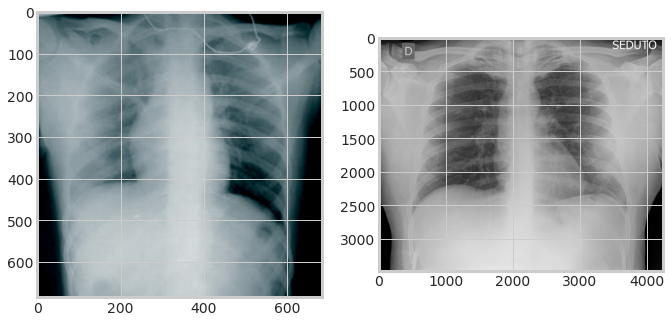

In [ ]:
#show sample image
samp_img1 = PIL.Image.open(os.path.join(train_dir, pics_with_covid['X_ray_image_name'].iloc[8]))
samp_img2 = PIL.Image.open(os.path.join(train_dir, pics_with_covid['X_ray_image_name'].iloc[15]))
fig, ax =plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(samp_img1);
ax[1].imshow(samp_img2);

In [ ]:
# Now we will only take data that is either normal, or infected with Covid
# This removes pneumonia images (non-covid).
# final_train_data = train_data[(train_data['Label'] == 'Normal') |
#                               ( (train_data['Label'] == 'Pnemonia') & (train_data['Label_2_Virus_category'] == 'COVID-19') ) 
#                               ( (train_data['Label'] == 'Pnemonia') & (train_data['Label_2_Virus_category'] == 'COVID-19') ) 
                              
#                               ]

final_train_data = train_data

final_train_data.head()

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,unknown,unknown
1,1,IM-0127-0001.jpeg,Normal,TRAIN,unknown,unknown
2,2,IM-0125-0001.jpeg,Normal,TRAIN,unknown,unknown
3,3,IM-0122-0001.jpeg,Normal,TRAIN,unknown,unknown
4,4,IM-0119-0001.jpeg,Normal,TRAIN,unknown,unknown


In [ ]:
# Make new column class which will hold neg or positive if the label is normal or not.
# final_train_data['class'] = final_train_data.Label.apply(lambda x: 'negative' if x=='Normal' else 'positive')
# test_data['class'] = test_data.Label.apply(lambda x: 'negative' if x=='Normal' else 'positive')

# final_train_data['target'] = final_train_data.Label.apply(lambda x: 0 if x=='Normal' else 1)
# test_data['target'] = test_data.Label.apply(lambda x: 0 if x=='Normal' else 1)

final_train_data['class'] = final_train_data.Label_2_Virus_category.apply(lambda x: 'positive' if x=='COVID-19' else 'negative')
test_data['class'] = test_data.Label_2_Virus_category.apply(lambda x: 'positive' if x=='COVID-19' else 'negative')

final_train_data['target'] = final_train_data.Label_2_Virus_category.apply(lambda x: 1 if x=='COVID-19' else 0)
test_data['target'] = test_data.Label_2_Virus_category.apply(lambda x: 1 if x=='COVID-19' else 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

In [ ]:
final_train_data

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category,class,target
0,0,IM-0128-0001.jpeg,Normal,TRAIN,unknown,unknown,negative,0
1,1,IM-0127-0001.jpeg,Normal,TRAIN,unknown,unknown,negative,0
2,2,IM-0125-0001.jpeg,Normal,TRAIN,unknown,unknown,negative,0
3,3,IM-0122-0001.jpeg,Normal,TRAIN,unknown,unknown,negative,0
4,4,IM-0119-0001.jpeg,Normal,TRAIN,unknown,unknown,negative,0
...,...,...,...,...,...,...,...,...
5281,5304,1-s2.0-S0929664620300449-gr2_lrg-c.jpg,Pnemonia,TRAIN,COVID-19,Virus,positive,1
5282,5305,1-s2.0-S0929664620300449-gr2_lrg-b.jpg,Pnemonia,TRAIN,COVID-19,Virus,positive,1
5283,5306,1-s2.0-S0929664620300449-gr2_lrg-a.jpg,Pnemonia,TRAIN,COVID-19,Virus,positive,1
5284,5307,1-s2.0-S0140673620303706-fx1_lrg.jpg,Pnemonia,TRAIN,COVID-19,Virus,positive,1


In [ ]:
# Take only the columns we need.
final_train_data = final_train_data[['X_ray_image_name', 'class', 'target', 'Label_2_Virus_category']]
final_test_data = test_data[['X_ray_image_name', 'class', 'target']]

In [ ]:
final_test_data

,X_ray_image_name,class,target
5286,IM-0021-0001.jpeg,negative,0
5287,IM-0019-0001.jpeg,negative,0
5288,IM-0017-0001.jpeg,negative,0
5289,IM-0016-0001.jpeg,negative,0
5290,IM-0015-0001.jpeg,negative,0
...,...,...,...
5905,person1637_virus_2834.jpeg,negative,0
5906,person1635_virus_2831.jpeg,negative,0
5907,person1634_virus_2830.jpeg,negative,0
5908,person1633_virus_2829.jpeg,negative,0


In [ ]:
test_data['Label'].value_counts()

Pnemonia    390
Normal      234
Name: Label, dtype: int64

In [ ]:
# Tensorflow ImageDataGenerator for augmentation
datagen =  ImageDataGenerator(
  shear_range=0.2,
  zoom_range=0.2,
  # rotation_range=5,
  # width_shift_range=0.2,
  # height_shift_range=0.2,
  # zca_whitening
  # brighhtness_range
  horizontal_flip=True
)
# todo: don't apply on only covid images. 
# Check out datagen.flow_from_Directory

# Converts dataset imgs to arrays by div / 255
def read_img(filename, size, path):

    img = image.load_img(os.path.join(path, filename), target_size=size)

    # Use img_to_array() built in method
    img = image.img_to_array(img) / 255
    return img

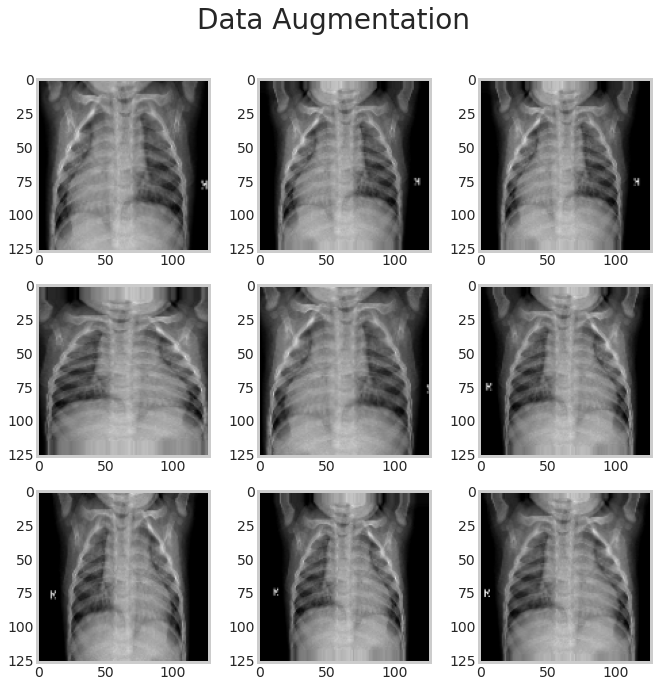

In [ ]:
mv = 127 # temp

# Test if read_img() function works
samp_img = read_img(final_train_data['X_ray_image_name'][0],
                                 (mv, mv),
                                 train_dir)

plt.figure(figsize=(10,10))
plt.suptitle('Data Augmentation', fontsize=28)

i = 0

# Display soem of the augmented images
for batch in datagen.flow(tf.expand_dims(samp_img,0), batch_size=6):
    plt.subplot(3, 3, i+1)
    plt.grid(False)
    plt.imshow(batch.reshape(mv, mv, 3));
    
    if i == 8:
        break
    i += 1
    
plt.show();

In [ ]:
# Take slice of dataframe of only covid19 images
corona_df = final_train_data[final_train_data['Label_2_Virus_category'] == 'COVID-19']
with_corona_augmented = []

# Augmentation function, process in batches
def augment(name):
    img = read_img(name, (mv, mv), train_dir)
    i = 0
    for batch in tqdm(datagen.flow(tf.expand_dims(img, 0), batch_size=32)):
        with_corona_augmented.append(tf.squeeze(batch).numpy())
        if i == 20:
            break
        i =i+1

# Apply the actual augmentation to the slices with covid19
corona_df['X_ray_image_name'].apply(augment)

  0%|          | 0/1 [00:00<?, ?it/s]


5221    None
5222    None
5223    None
5224    None
5225    None
5226    None
5227    None
5228    None
5229    None
5230    None
5237    None
5238    None
5239    None
5240    None
5242    None
5243    None
5244    None
5245    None
5246    None
5247    None
5248    None
5249    None
5250    None
5251    None
5252    None
5253    None
5254    None
5255    None
5256    None
5257    None
5258    None
5259    None
5260    None
5261    None
5262    None
5263    None
5264    None
5265    None
5266    None
5267    None
5268    None
5269    None
5270    None
5271    None
5272    None
5273    None
5274    None
5275    None
5276    None
5277    None
5278    None
5279    None
5280    None
5281    None
5282    None
5283    None
5284    None
5285    None
Name: X_ray_image_name, dtype: object

In [ ]:
# Extract images from traing data and test data, then convert them as array
train_arrays = [] 
final_train_data['X_ray_image_name'].apply(lambda x: train_arrays.append(read_img(x, (mv,mv), train_dir)))

#test_arrays = []
#final_test_data['X_ray_image_name'].apply(lambda x: test_arrays.append(read_img(x, (mv,mv), test_dir)))


0       None
1       None
2       None
3       None
4       None
        ... 
5281    None
5282    None
5283    None
5284    None
5285    None
Name: X_ray_image_name, Length: 5286, dtype: object

In [ ]:
print(len(train_arrays))
print(len(test_arrays))

5286
624


In [ ]:
# Concatenate the training data labels and the labels for augmented images
y_train = np.concatenate((np.int64(final_train_data['target'].values), np.ones(len(with_corona_augmented), dtype=np.int64)))

train_arrays, test_arrays, y_train, y_test = train_test_split(train_arrays, y_train, stratify=y_train, test_size=.15)




In [ ]:
# For x_train tensors, make sure to include augmented images.
x_train_tensors = tf.convert_to_tensor(np.concatenate((np.array(train_arrays), np.array(with_corona_augmented))))
x_test_tensors  = tf.convert_to_tensor(np.array(test_arrays))

y_train_tensors = tf.convert_to_tensor(y_train)
y_test_tensors = tf.convert_to_tensor(final_test_data['target'].values)

In [ ]:
# Create a dataset from tensors. Use tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_tensors, y_train_tensors))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_tensors, y_test_tensors))

In [ ]:
BATCH_SIZE = 16
BUFFER = 1000

# Shuffle train batches to make sure we mix up covid and non covid images.
train_batches = train_dataset.shuffle(BUFFER).batch(BATCH_SIZE)
test_batches = test_dataset.batch(BATCH_SIZE)


for i,l in train_batches.take(1):
    print('Train Shape per Batch: %s' % str(i.shape));

for i,l in test_batches.take(1):
    print('Test Shape per Batch: %s ' % str(i.shape));

Train Shape per Batch: (16, 127, 127, 3)
Test Shape per Batch: (16, 127, 127, 3) 


In [ ]:
# Get pretrained model, for now use ResNet with pretrained weights.
pretrained_resnet = tf.keras.applications.ResNet50(input_shape=(mv,mv,3),
                                               include_top=False,
                                               weights='imagenet')

# We are using pretrained weights, set trainable=false
pretrained_resnet.trainable = False
pretrained_resnet.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 127, 127, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 133, 133, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
__________________________

In [ ]:
for i,l in train_batches.take(1):
    pass
pretrained_resnet(i).shape

TensorShape([16, 4, 4, 2048])

Model

In [ ]:
model = Sequential()

model.add(pretrained_resnet) # Add resnet model
model.add(Layers.GlobalAveragePooling2D()) # Adding a flatten layer throws an error for some reason.
model.add(Layers.Dense(64))
model.add(Layers.Dropout(0.2)) # Mess around with this to prevent overfitting.
model.add(Layers.Dense(1, activation = 'sigmoid')) # Final layer sigmoid bc binary classification

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                131136    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 23,718,913
Trainable params: 131,201
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

model.compile(optimizer='adam',
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(train_batches, epochs=10, validation_data=test_batches, callbacks=[callbacks], shuffle=True)

Epoch 1/10
407/407 [==============================] - 15s 30ms/step - loss: 0.0883 - accuracy: 0.9539 - val_loss: 1.2114 - val_accuracy: 0.0000e+00
Epoch 2/10
407/407 [==============================] - 11s 27ms/step - loss: 0.0971 - accuracy: 0.9457 - val_loss: 0.8612 - val_accuracy: 0.0881
Epoch 3/10
407/407 [==============================] - 11s 27ms/step - loss: 0.0928 - accuracy: 0.9563 - val_loss: 0.9641 - val_accuracy: 0.0769
Epoch 4/10
407/407 [==============================] - 11s 27ms/step - loss: 0.0959 - accuracy: 0.9496 - val_loss: 0.8231 - val_accuracy: 0.3189
Epoch 5/10
407/407 [==============================] - 11s 27ms/step - loss: 0.0754 - accuracy: 0.9754 - val_loss: 0.9625 - val_accuracy: 0.2612
Epoch 6/10
407/407 [==============================] - 11s 27ms/step - loss: 0.0769 - accuracy: 0.9594 - val_loss: 0.7229 - val_accuracy: 0.5369
Epoch 7/10
407/407 [==============================] - 11s 27ms/step - loss: 0.0690 - accuracy: 0.9748 - val_loss: 0.6562 - val_accur

In [ ]:
# Save model to drive 
model.save('drive/MyDrive/corona_dataset/saved_model/model2')

INFO:tensorflow:Assets written to: drive/MyDrive/corona_dataset/saved_model/model/assets


In [ ]:
prediction = (model.predict(np.array(test_arrays)) > 0.5).astype("int32")

In [ ]:
print(prediction)

[[1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]


In [ ]:
print(classification_report(test_data['target'], prediction.flatten()))

              precision    recall  f1-score   support

           0       1.00      0.86      0.92       624
           1       0.00      0.00      0.00         0

    accuracy                           0.86       624
   macro avg       0.50      0.43      0.46       624
weighted avg       1.00      0.86      0.92       624



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


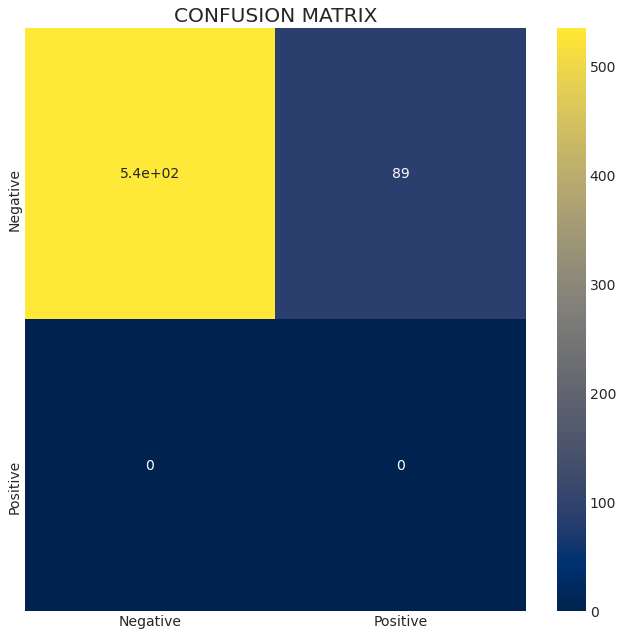

In [ ]:
con_mat = confusion_matrix(test_data['target'], prediction.flatten())
plt.figure(figsize = (10,10))
plt.title('CONFUSION MATRIX')
sns.heatmap(con_mat, cmap='cividis',
            yticklabels=['Negative', 'Positive'],
            xticklabels=['Negative', 'Positive'],
            annot=True);

In [ ]:
# Must append singular image into an empty array for some reason... Do not question it
# Testing a single image upload
t_a = []
img = image.load_img('drive/MyDrive/corona_dataset/test_image_nn.jpeg', target_size=(127,127))
img = image.img_to_array(img) / 255
t_a.append(img)
single_img_pred = (model.predict(np.array(t_a)) > 0.5).astype("int32")

class_chosen = single_img_pred[0][0]

outcomes = {
    0 : "Not COVID",
    1 : "COVID"
}


print(outcomes[ class_chosen ])


Not COVID


In [ ]:
# Flask server going to be on my machine first. -Brian